# Reading updated headlines from file

To speed data processing up for later, we'll read in our freshly-processed headlines with Latitude, Longitude, and Country Code from a file.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/headlines_augmented.csv")

# Visualizing before Clustering

First, we'll try just looking at our data and make sure our data makes sense. From here, we can try "eyeballing" some values for k-mean clustering and DBSCAN.

In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import math

map_plotter = Basemap()

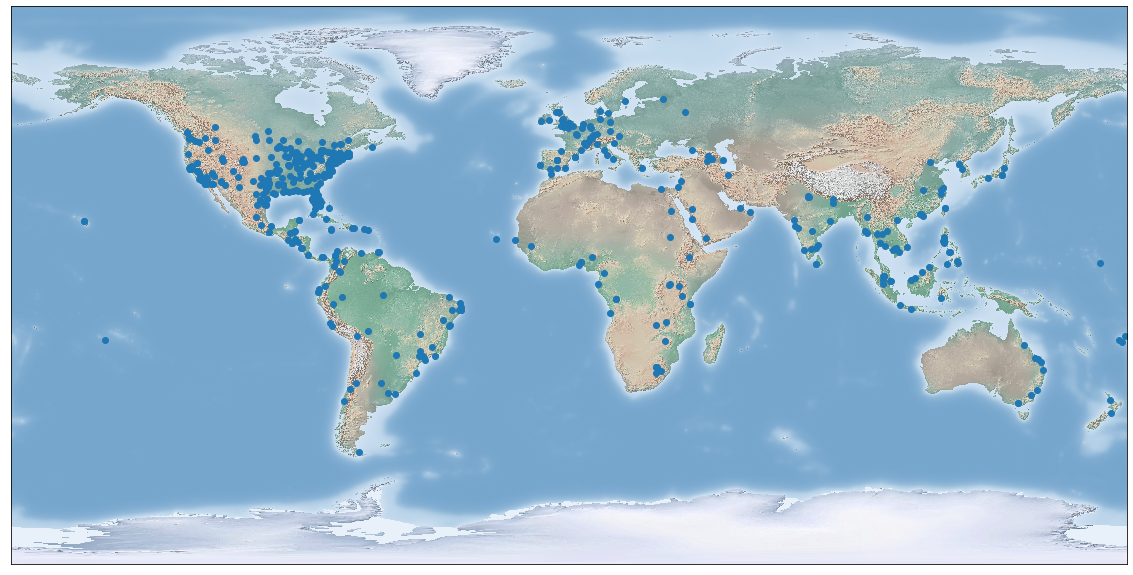

In [3]:
lat_long_pairs = df[['latitude', 'longitude']].to_numpy()
latitudes, longitudes = lat_long_pairs.T
fig = plt.figure(figsize=(20, 12))
map_plotter.scatter(longitudes, latitudes, latlon=True)
map_plotter.shadedrelief()
plt.show()

## Visualizing: K-Mean Elbow Plotting

Since there are many reasonably-sized centers of points, we'll try elbow plotting to figure out a reasonable k-value. 

k≥6 may be a good first guess, since there are 6 continents with points.

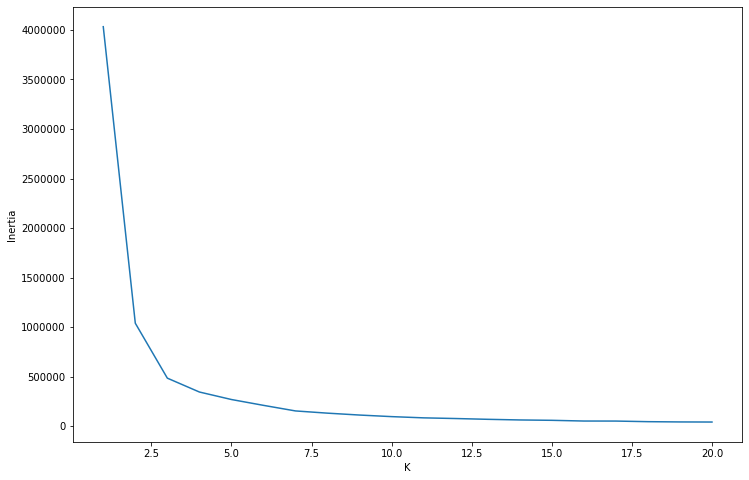

1: 4033338.336
2: 1038622.470
3: 483871.819
4: 343932.201
5: 268137.069
6: 209182.391
7: 152755.610
8: 130327.299
9: 111238.953
10: 95335.085
11: 82906.948
12: 76042.061
13: 68141.064
14: 61712.784
15: 58032.413
16: 50815.172
17: 50441.447
18: 44345.086
19: 41609.897
20: 40697.601


In [4]:
k_values = range(1, 21)
inertia_values = [KMeans(n_clusters=i).fit(lat_long_pairs).inertia_ for i in k_values]

plt.figure(figsize=(12, 8))
plt.plot(k_values, inertia_values)
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()
for i, v in enumerate(inertia_values, start=1):
    print(f"{i}: {v:.3f}")

# Clustering: K-Means

Since 5 is the last "elbow" in the curve, it looks like a guess of 6 wasn't a bad start. We'll still try 6 as our k-value, and create a DataFrame with this number of clusters in mind. However, this may not prove optimal since we're interested in dense outbreak regions rather than outbreak regions with a certain center.

In [5]:
# From https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
# Used for colormapping more than 10 colors, to prevent
# different clusters in close proximity from causing confusion when drawn
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [6]:
NUM_CLUSTERS = 16
clusters = KMeans(n_clusters=NUM_CLUSTERS).fit_predict(lat_long_pairs)
df_kmean = df.copy()
df_kmean['cluster'] = clusters

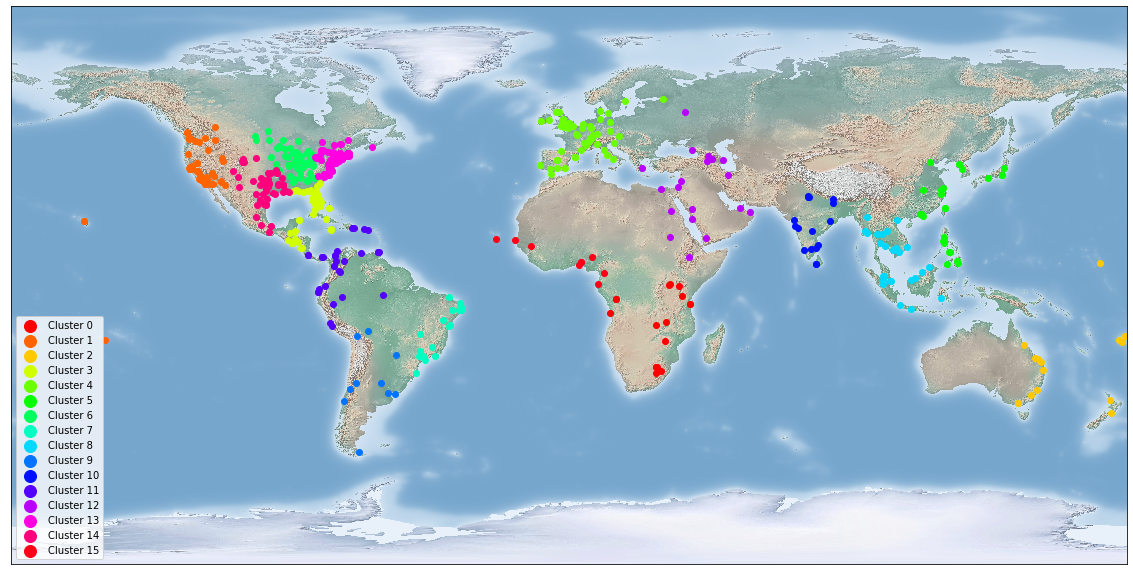

In [7]:
plt.figure(figsize=(20, 12))
cluster_group = df_kmean.groupby('cluster')
cmap = get_cmap(len(cluster_group))
for cluster_id, cluster in cluster_group:
    if cluster_id == -1: continue
    map_plotter.scatter(cluster.longitude, cluster.latitude, latlon=True, color=cmap(cluster_id))
    
map_plotter.shadedrelief()
plt.legend( [f"Cluster {cid}" for cid, _ in cluster_group if cid != -1], \
               loc="lower left", markerscale=2, fontsize="medium" )
plt.show()

So while at first glance this map looks fine (k=6), there are some obvious problems (e.g. Pacific Asia and Australia are one cluster) that indicate we have to change some parameters. In this case, we'll add more than 6 clusters.

After further experimentation based on the interia values calculated above, k=16 seems to be a reasonable number of clusters.

# Clustering: DBSCAN

Since we're trying to locate clusters of regions based on the proximity of other cities in distress, it may be a good idea to do density-based clustering, since certain regions may be more dense than others and require a limiting of resources, or require more resources to cover a larger area, etc.

In [8]:
# Based on the Haversine formula, found here: https://www.movable-type.co.uk/scripts/latlong.html
def great_circle(point_1, point_2):
    RADIUS = 6371  # Kilometers, Earth's mean radius
    lat_1 = math.radians(point_1[0])
    lat_2 = math.radians(point_2[0])
    d_lat = lat_2 - lat_1
    d_long = math.radians(point_2[1] - point_1[1])
    a = math.sin(d_lat/2) * math.sin(d_lat/2) + math.cos(lat_1) \
            * math.cos(lat_2) * math.sin(d_long/2) * math.sin(d_long/2)
    c = 2 * math.atan2(np.sqrt(a), np.sqrt(1-a))
    return RADIUS * c

First, we'll run the DBSCAN procedure and create an augmented DataFrame with the new clusters. The values for `MAX_KM` and `MIN_LOC` were experimentally determined, the process and code I used can be found under the **DBSCAN: Experimentation** heading.

In [12]:
MAX_KM = 500  # 403km is about 250 miles
MIN_LOC = 3
clusters = DBSCAN(eps=MAX_KM, min_samples=MIN_LOC, metric=great_circle).fit_predict(lat_long_pairs)
df_dbscan = df.copy()
df_dbscan['cluster'] = clusters

Then, we'll plot our results and see if we should change some parameters.

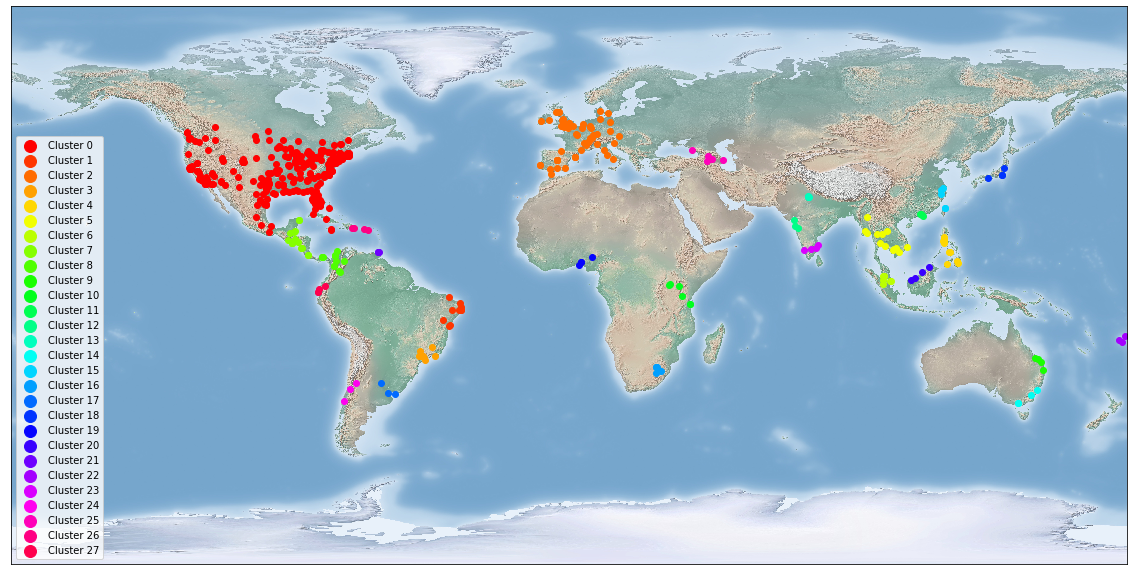

In [13]:
cluster_group = df_dbscan.groupby('cluster')
plt.figure(figsize=(20, 12))
cmap = get_cmap(len(cluster_group))
for cluster_id, cluster in cluster_group:
    if cluster_id == -1: continue
    map_plotter.scatter(cluster.longitude, cluster.latitude, latlon=True, color=cmap(cluster_id))
    
map_plotter.shadedrelief()
plt.legend( [f"Cluster {cid}" for cid, _ in cluster_group if cid != -1], \
               loc="lower left", markerscale=2, fontsize="medium" )
plt.show()

If I find this clustering to be insufficient later on, it should be fairly easy to modify its parameters.

## DBSCAN: Experimentation

Since I don't have any experience with DBSCAN (or data clustering in general), I decided to do some experimentation with DBSCAN's `eps` and `min_samples` parameters to get a feeling for how both of these parameters would affect the result. The cell has been converted to a "raw" cell to prevent execution, and remains here merely to document my thought process.

### `eps` tuning
As the maximum distance between each point/city increased, I found that the number of clusters had decreased -- for example, several US clusters had merged into one large cluster when going from 400km to 500km. This did not affect other countries as much in terms of cluster size. However, it did begin to include otherwise far-away cities to add to each cluster. This could potentially add noise to each cluster, so I made sure not to go too high in terms of distance.

I eventually decided that the best `eps` value would be in the range 400-550, since beyond that and it begins to include too many far cities into one cluster and ruined the "centrality" of each. I eventually settled on **500km** as it didn't ignore smaller clusters of cities (for example, some cities in South America) while also not spreading out each point in the cluster too far.
### `min_samples` tuning
I started with 3, 4, 5, and 6 as possible numbers of minimum cities per cluster, but quickly found that 5 and 6 were removing too many data points. While they made each cluster more "significant" by having only larger (and potentially more at risk) areas, they excluded some smaller areas that may require examination. 4 seemed like a reasonable compromise, but still eliminated some clusters that I felt should remain (e.g. Malaysia was removed with a 4 city minimum).

# DBSCAN: Euclidean Clustering (after the fact)

**Note**: This section was added after looking at the solution, and was not done during my initial experimentation with DBSCAN. The only metric I had used then was the great circle distance. This is mainly to "play around" with the euclidean metric, since I didn't think to do that originally.

In [35]:
euclid_clusters = DBSCAN(eps=9, min_samples=3).fit_predict(lat_long_pairs)
df_euclid_dbscan = df.copy()
df_euclid_dbscan['cluster'] = euclid_clusters

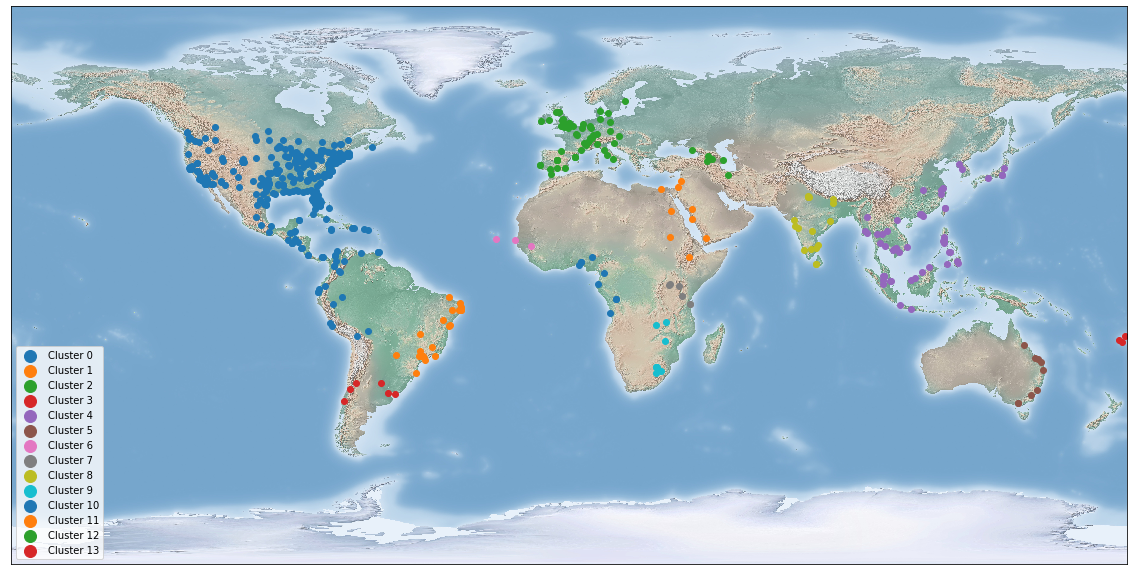

In [36]:
plt.figure(figsize=(20,12))
cluster_group = df_euclid_dbscan.groupby('cluster')
for cluster_id, cluster in cluster_group:
    if cluster_id == -1: continue
    map_plotter.scatter(cluster.longitude, cluster.latitude, latlon=True)
map_plotter.shadedrelief()
#map_plotter.drawcoastlines()
#map_plotter.drawcountries()
plt.legend( [f"Cluster {cid}" for cid, _ in cluster_group if cid != -1], \
                loc="lower left", markerscale=2, fontsize="medium" )
plt.show()